<a href="https://colab.research.google.com/github/waleedrizwan/portfolioanalysistool/blob/main/Portfolio_Analysis_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download your own copy of this notebook, and then upload it to your own Colab account or any other Jupytr Notebook editor **




# Ctrl + F9, To Run All cells in descending order 

In [ ]:
## Run this cell once to download / import all necessary libraries/ packages

# Yfinance API not included in base environment so it must be installed 
!pip install yfinance

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

 # improves appearance of charts 
import seaborn as sns
sns.set
import yfinance as yf

from scipy.optimize import minimize

# **Portfolio Returns Section**

In the list "tickers" below, enter the ticker name of each stock you want 
included in the portfolio

In list "weights" add the % of the portfolio invested in each asset as a float where the sum of weights = 1. Or leave it as is and the portfolio will be equally invested in each equity. The index position of the weighting should match the corresponding index in list "tickers".

In [ ]:
## stores all ticker of all investments in the portfolio, used in API call to retreive data 
tickers = ["MSFT", "SPY", "AAPL", 'NFLX', 'KO', 'AMZN',]

num_stocks = len(tickers)

## Enter weights manually as list of float where sum = 1, each index must match tickers 
weights = [1 / num_stocks] * num_stocks

# joins each string
tickers_string = " ".join(tickers)

# set time span to use for analysis
start ="2013-01-01"
end="2020-10-20"
data = yf.download(tickers_string, start=start, end=end)

num_stocks = len(tickers)

## drops irrelevant columns and cleans dataframes for calculations
df = data.drop(['Close','High','Low','Open','Volume'], axis=1)
df.index.set_names(tickers[0][1])
df.reset_index(inplace=True)
# Set Dates as index of dataframe
df.set_index('Date', inplace=True)

[*********************100%***********************]  6 of 6 completed


Portfolio Return can be calculated by multiplying the return on each individual asset by its corresponding % weight in the portfolio

By taking the mean of historic returns we can find the daily expected return, and by multiplying by 250 (total trading days per year), we can find the annual expected return of the portfolio


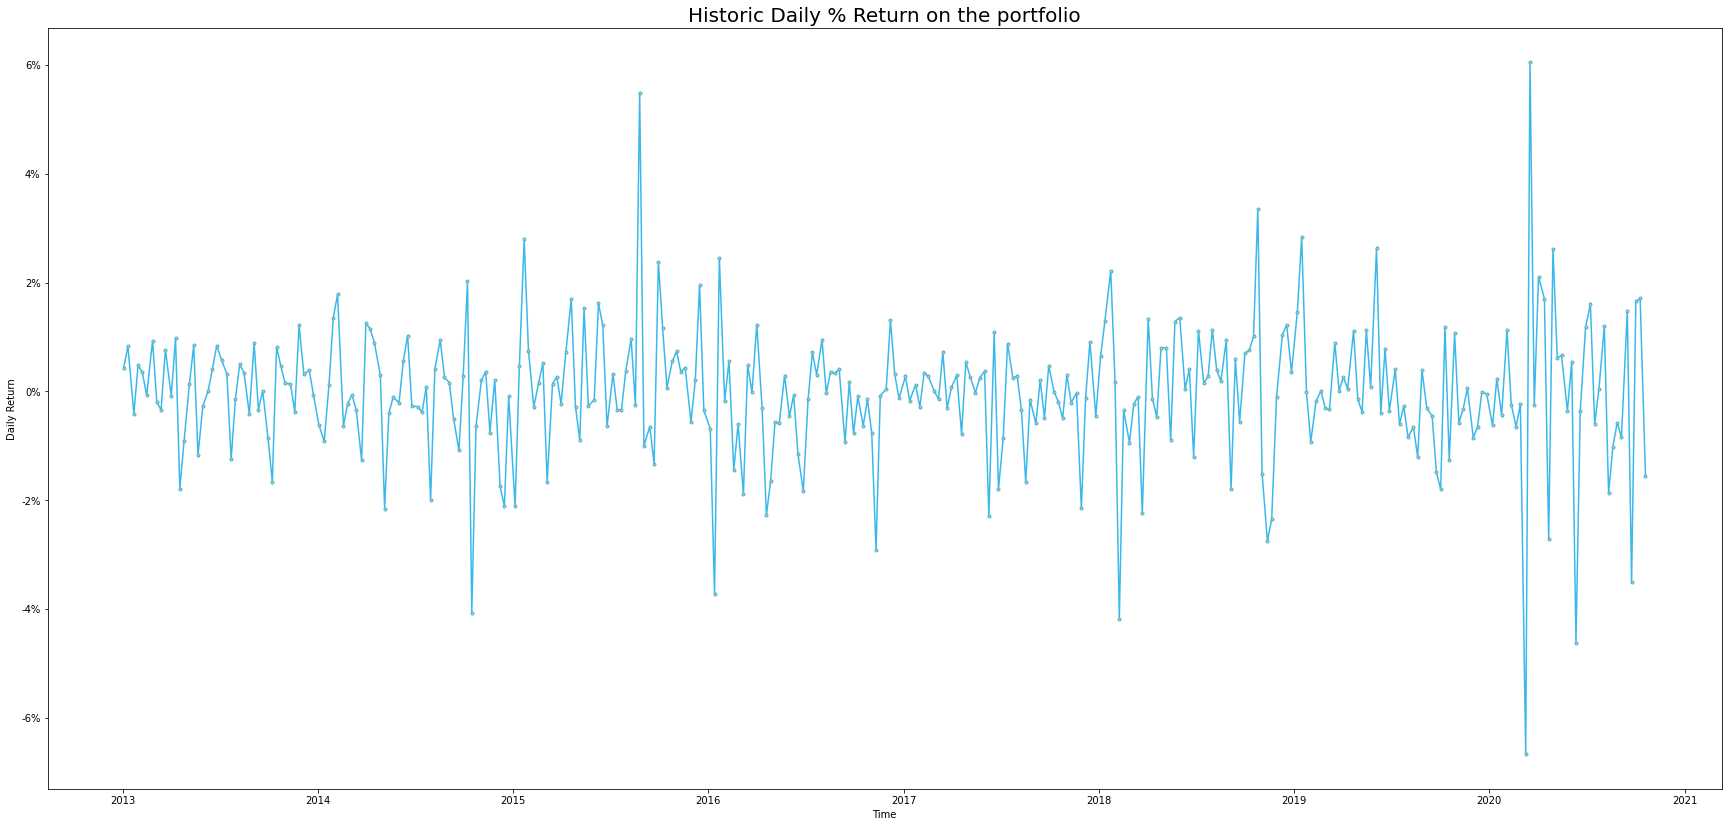

In [ ]:
# makes copy of original dataframe to be used for daily portfolio return calculation
df2 = df.copy()

# pct_change method can be used to calculate day by day percent change in price also known as daily return
df2 =df2.pct_change(1).dropna()

# for every asset return column, multiply by its weighting
i = 0
for (columnName, columnData) in df2.iteritems():
  df2[columnName] = df2[columnName] * weights[i]
  i+=1
  
# sum column contains the portfolios historical daily returns for the time period provided
df2["sum"] = df2.sum(axis=1)
df3 = df2['sum']

## every 6th point is selected to make plot more readable
n=6
df3 = df3[::n]

## Plots daily return series
plt.figure(figsize=(30, 14))
plt.title('Historic Daily % Return on the portfolio', fontsize=20)
plt.plot(df3, marker='.', color='#39b8eb', markerfacecolor='#ffbd4a')
plt.xlabel('Time')
plt.ylabel('Daily Return')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

In [ ]:
def getPortReturn(dataframe,weights):
  '''
  Use numpy dot and transpose methods to multiply
  individual expected stock returns by corresponding portfolio 
  weighting, returns annualized expected portfolio return 

  '''
  
  # Creates a dataframe of daily % returns on each asset
  returns_df = df.pct_change(1).dropna()

  exp_ret_portfolio = np.dot(np.transpose(weights), returns_df.mean()) * 250
  return exp_ret_portfolio


In [ ]:
print("The Expected Annual Return of the portfolio is : ", np.round(getPortReturn(df,weights),3))


The Expected Annual Return of the portfolio is :  0.295


# **# Portfolio Risk Calculations**



Total risk of a portfolio can be calculated as,

Total Risk = Firm Specific Risk (undiversifiable risk) + Market Risk

A commonly accepted measure of total risk is **Standard Deviation**, also called **Volatility**


Standard deviation of an assets price, tells us how the much the price varies or swings back and forth between gains and losses over time.

Market Risk is usually measured using **Beta** , which indicates how the value moves in accordance to the overall stock market 








In [ ]:
# variance covariance matrix for portfolio 
# matrix represents covariance between all assets on a pair basis 

returns_df = df.pct_change(1).dropna()

vcv_matrix = returns_df.cov()

# transpose the vector of weights  multiplied by the product of vcv matrix and vector of weights
# formula for variance of the portfolio 
var_p = np.dot(np.transpose(weights), np.dot(vcv_matrix, weights)) # multiplies the matrices

## StD of the portfolio, daily
sd_p = np.sqrt(var_p)
sd_p_annual = sd_p * np.sqrt(250)

print("Annualized Standard deviation or Volatility of the portfolio = " , round(sd_p_annual, 3))

Annualized Standard deviation or Volatility of the portfolio =  0.202


In [ ]:
## Annual volatility of each asset
returns_df = df.pct_change(1).dropna()

individual_risks = np.std(returns_df) * np.sqrt(250)
individual_risks

Adj Close  AAPL    0.283799
           AMZN    0.305412
           KO      0.180295
           MSFT    0.264046
           NFLX    0.459090
           SPY     0.167685
dtype: float64

**Beta** is a measure of market risk. 

It indicates the strength and direction of the relationship between the portfolio value and performance in the overall market

The magnitude of Beta is between 0 and 1

1 representing perfect movements with the markets

0 meaning the performance of the market has no effect on the price of the asset 

The market in Beta calculations is usually represented by an index such as the S&P500 or the NASDAQ. 

Beta is calculated by diving the Covariance of the asset and the index by the variance of the index 

Ra = return on asset
Rj = return on the market

B = Cov(Ra, Rj) / Var(Rm)





In [ ]:
## Beta of each Asset

## Calculates Covariance between the market and each asset 


def calculateBeta(asset_ticker, index_ticker):
  '''
  calculates beta of a given stock using a, index fund to represent the market portfolio
  first finds covariance between the assets then divides by the variance of the 
  market portfolio using np.var method 

  '''
   
  df =  yf.download(asset_ticker, start="2010-01-01", end="2020-10-17")
  df.reset_index(level =0, inplace=True) # converts date from index to col
  df.rename(columns = {'Date': 'date', "Adj Close": 'Stock_Price'}, inplace=True)

  # Enter Market index ticker here
  df2 =  yf.download(index_ticker, start="2010-01-01", end="2020-10-17")
  df2.reset_index(level =0, inplace=True) # converts date from index to col
  df2.rename(columns = {'Date': 'date', "Adj Close": 'Market_Price'}, inplace=True)

  df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
  df2 = df2.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
  # Inner join the two dataframes
  data = pd.merge(left=df, right=df2, left_on='date', right_on='date')

  data.set_index('date', inplace= True)
  data.head() 
  
  # Calculates daily pct return on both assets 
  returns_df = data.pct_change(1)
  returns_df.dropna(inplace=True)# Drop NaN values 
  returns_df.rename(columns = {'Stock_Price': 'Stock_Return%', "Market_Price": 'Market_Return%'}, inplace=True)
  returns_df.head()

  ## Calculates Covariance between the two assets
  deviations = returns_df - returns_df.mean() # rj - E[rj] and rm - E[rm]
  deviations.rename(columns = {'Stock_Return%': 'Stock_Deviations', "Market_Return%": 'Market_Deviations'}, inplace=True)

  product_deviations = deviations['Stock_Deviations'] * deviations['Market_Deviations']

  cov_market_stock = product_deviations.sum() / (len(product_deviations) - 1)

  ## Calculates variance of market, using % daily returns 
  market_var = np.var(returns_df['Market_Return%'], ddof=1)

  ## Calcuates beta of the stock, in relation to the market index 
  stock_beta = cov_market_stock / market_var
 
  return stock_beta


# find beta for each asset in the portfolio 
indexString = "^GSPC" # S&P 500 
portfolioBetas = {}


for stock in tickers: 
  portfolioBetas[stock] = calculateBeta(stock,indexString) 


## Prints the beta of each stock in accordance to the given index fund 
for beta in portfolioBetas:
    print(repr(beta),":",portfolioBetas[beta])


weightsDict = {}

i = 0
for x in tickers:
  weightsDict[x] = weights[i]
  i+=1

portBeta = 0

for x in tickers:
  tempSum = weightsDict[x] * portfolioBetas[x]
  portBeta += tempSum


print("The beta of the portfolio is: ",round(portBeta,4)) 


objects = []

for x in tickers:
  objects.append(x)

objects.append("Portfolio")  

tuple(objects)


performance = []

for x in portfolioBetas:
  performance.append(portfolioBetas[x])

performance.append(portBeta)

tuple(performance)


y_pos = np.arange(len(objects))




plt.figure(figsize=(25, 14))
plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects, fontsize = 20)
plt.ylabel('Beta', fontsize =20)

plt.title('Portfolio Beta Analysis',fontsize = 20)


plt.show()



# **Portfolio Summary**




In [ ]:
print("The Expected Annual % Return of the portfolio is : ", np.round(getPortReturn(df,weights),3))

print("Annualized Volatility (Std) of the portfolio = " , round(sd_p_annual, 3))

print("The beta of the portfolio with index " + indexString+ " is: ",round(portBeta,4)) 



The Expected Annual % Return of the portfolio is :  0.295
Annualized Volatility (Std) of the portfolio =  0.202
The beta of the portfolio with index ^GSPC is:  0.966
